In [15]:
%matplotlib inline

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [17]:
matplotlib.style.use("ggplot")

In [18]:
# Consider value '0' as NaN.
xm_settle = pd.read_csv("8_m_settle.csv", usecols=range(1,10),
                        parse_dates=[0], header=0, index_col=0, na_values=0)
xm_symbols = pd.read_csv("8_m_symbols.csv", usecols=range(1,10), parse_dates=[0],
                         header=0, index_col=0, na_values=0)
expiration_months = pd.read_csv("expiration.months.csv", usecols=range(1,14), 
                                parse_dates=[0], header=0, index_col=0, na_values=0)
vix_index = pd.read_csv("vix.csv", parse_dates=[0], header=0, index_col=0)

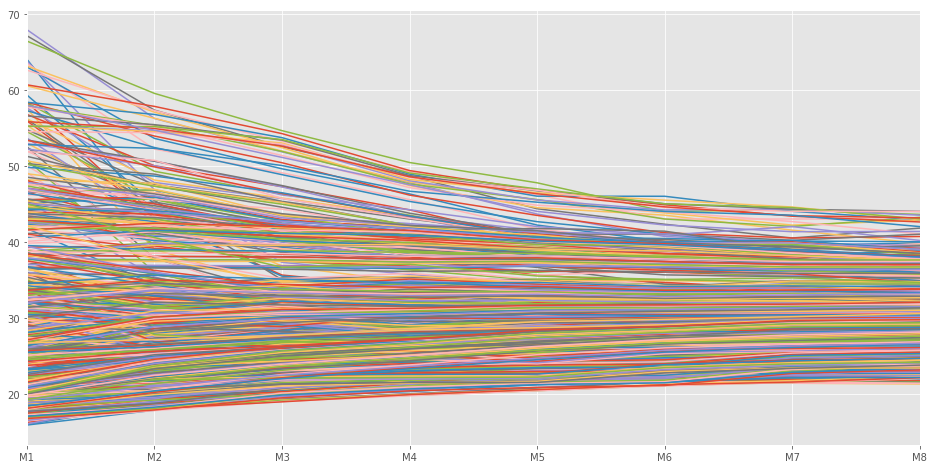

In [23]:
# Plot part of the data.
lines = xm_settle.iloc[1000:2000].T
lines.fillna(method='pad').plot(legend=False, figsize=(16,8))

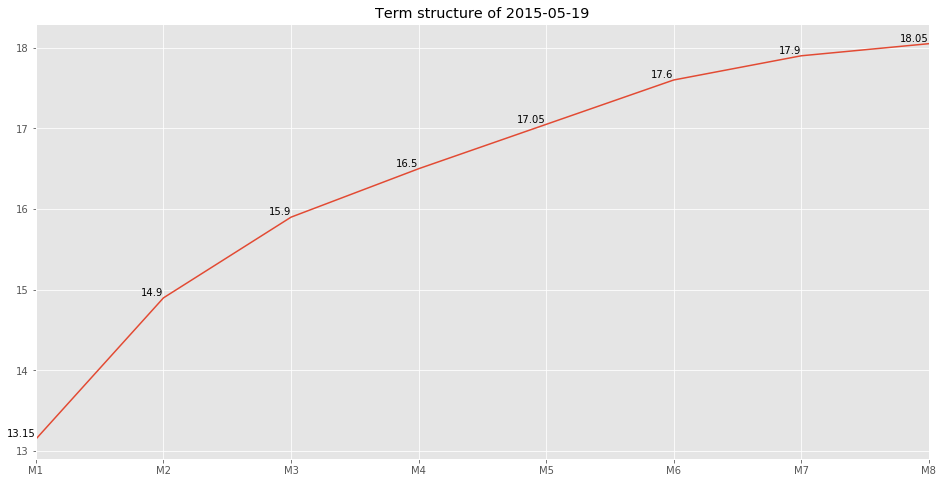

In [22]:
data_line = xm_settle.iloc[-500]
data_line.T.plot(legend=False, figsize=(16,8))
for i in range(len(data_line)):
    plt.text(i, data_line[i], data_line[i], horizontalalignment="right", verticalalignment="bottom")
plt.title(f"Term structure of {data_line.name.date()}")

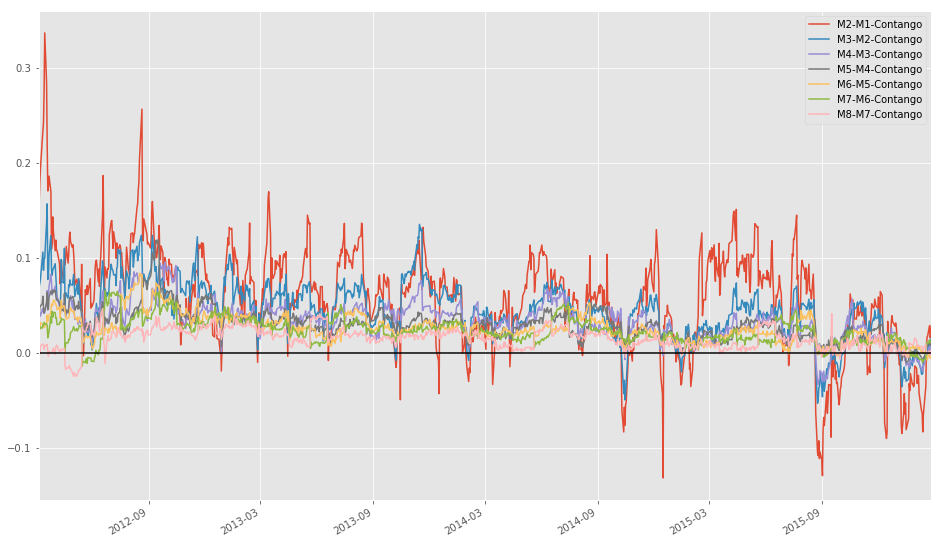

In [13]:
m5 = xm_settle["M5"][2000:3000]
m4 = xm_settle["M4"][2000:3000]
m3 = xm_settle["M3"][2000:3000]
mxs = [xm_settle.iloc[2000:3000, i] for i in range(8)]
contangos = [(mxs[i + 1] - mxs[i]) / mxs[i] for i in range(8 - 1)]
contango_labels = ["M{}-M{}-Contango".format(i+1, i) for i in range(1,8)]
plt.figure(figsize=(16,10))
for i in range(len(contangos)):
    contangos[i].plot(label=contango_labels[i], legend=True)
plt.axhline(0, color="black")
plt.xlabel("")

In [83]:
vix = vix_index["Adj Close"]
trainingdata = pd.merge(pd.DataFrame(vix), xm_settle, left_index=True, right_index=True)
trainingdata = trainingdata.fillna(0)
trainingdata.shape

(3305, 9)